In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def generate_force_profile(S_phases, F_values):
    time = []
    force = []
    current_time = 0
    
    # Ramp-up
    time.extend(np.linspace(current_time, current_time + S_phases[0], num=100))
    force.extend(np.linspace(0, F_values, num=100))
    current_time += S_phases[0]
    
    # Steer
    time.extend(np.linspace(current_time, current_time + S_phases[1], num=100))
    force.extend([F_values] * 100)
    current_time += S_phases[1]
    
    # Ramp-down
    time.extend(np.linspace(current_time, current_time + S_phases[2], num=100))
    force.extend(np.linspace(F_values, 0, num=100))
    current_time += S_phases[2]
    
    # Free
    time.extend(np.linspace(current_time, current_time + S_phases[3], num=100))
    force.extend([0] * 100)
    
    return time, force

In [3]:
# Expanding the data to represent the entire table for better simulation
expanded_data = {
    "Set Name": [
        "1", "2", "12", "12χ", "126χ", "186", "129χ", "129-10χ", 
        "126χ-(F1)", "126χ-(F2)", "126χ-(S1)", "126χ-(S2)", "126χ-(S3)", 
        "6-12χ", "126α3χ-(a)", "126α3χ-(b)", "126α3χ-(c)", "126α3χ-(d)"
    ],
    "CVs steered": [
        ["d1"], ["d2"], ["d1", "d2"], ["d1", "d2", "χ1"], ["d1", "d2", "d6", "χ1"],
        ["d1", "d8", "d6"], ["d1", "d2", "d9", "χ1"], ["d1", "d2", "d9", "d10", "χ1"],
        ["d1", "d2", "d6", "χ1"], ["d1", "d2", "d6", "χ1"], ["d1", "d2", "d6", "χ1"],
        ["d1", "d2", "d6", "χ1"], ["d1", "d2", "d6", "χ1"], ["d1", "d2", "d6", "χ1"],
        ["d1", "d2", "d6", "comα3", "χ1"], ["d1", "d2", "d6", "comα3", "χ1"],
        ["d1", "d2", "d6", "comα3", "χ1"], ["d1", "d2", "d6", "comα3", "χ1"]
    ],
    "S": [
        "25-25-25-25", "25-25-25-25", "25-25-25-25", "25-25-25-25", "25-25-25-25",
        "25-25-25-25", "25-25-25-25", "25-25-25-25", "25-25-25-25", "25-25-25-25",
        "5-65-5-25", "5-75-5-15", "5-90-5-25", "scheduled", "5-25-5-25", "5-65-5-25",
        "5-25-25-25", "25-25-25-25"
    ],
    "F": [
        ["500"], ["500"], ["500", "500"], ["500", "500", "1000"], ["500", "500", "500", "1000"],
        ["500", "500", "500"], ["500", "500", "500", "1000"], ["500", "500", "500", "500", "1000"],
        ["200", "100", "50", "1000"], ["20", "10", "5", "1000"], ["500", "500", "500", "1000"],
        ["500", "500", "500", "1000"], ["500", "500", "500", "1000"], ["500", "500", "500", "1000"],
        ["500", "500", "500", "500", "1000"], ["500", "500", "500", "500", "1000"],
        ["500", "500", "500", "500", "1000"], ["500", "500", "500", "500", "1000"]
    ]
}

# Convert to DataFrame
expanded_df = pd.DataFrame(expanded_data)

# Ensure S_phases has "scheduled" values handled appropriately by marking those rows differently
def process_s_phases(s):
    if s == "scheduled":
        return None  # Mark scheduled differently for conditional plotting
    else:
        return list(map(int, s.split('-')))

expanded_df['S_phases'] = expanded_df['S'].apply(process_s_phases)

In [6]:
# Function to classify unique profile types based on S_phases pattern
def classify_profile_type(s_phases):
    if s_phases is None:
        return "Scheduled"
    elif len(set(s_phases)) == 1:
        return "I"  # All segments have the same duration
    elif s_phases == [5, 65, 5, 25]:
        return "II"  # Specific unique pattern
    elif s_phases == [5, 75, 5, 15]:
        return "III"  # Specific unique pattern
    elif s_phases == [5, 90, 5, 25]:
        return "IV"  # Specific unique pattern
    elif s_phases == [5, 25, 5, 25]:
        return "V"  # Specific unique pattern
    elif s_phases == [5, 65, 5, 25]:
        return "VI"  # Specific unique pattern, repeated
    elif s_phases == [5, 25, 25, 25]:
        return "VII"  # Specific unique pattern
    else:
        return "VIII"  # Default for any other unique pattern

# Convert lists in 'S_phases' to strings for uniqueness identification
expanded_df['S_phases_str'] = expanded_df['S_phases'].apply(lambda x: str(x) if x is not None else "Scheduled")
expanded_df['F_str'] = expanded_df['F'].apply(lambda x: str(x))
expanded_df['Profile Type'] = expanded_df['S_phases'].apply(classify_profile_type)

unique_profiles = expanded_df[['Profile Type', 'S_phases', 'F', 'S_phases_str', 'F_str']].drop_duplicates(subset=['Profile Type', 'S_phases_str', 'F_str']).reset_index(drop=True)


# Display unique profile types and example S_phases for each
unique_profile_types = expanded_df[['Profile Type', 'S_phases_str']].drop_duplicates().reset_index(drop=True)
unique_profile_types


,Profile Type,S_phases_str
0,I,"[25, 25, 25, 25]"
1,II,"[5, 65, 5, 25]"
2,III,"[5, 75, 5, 15]"
3,IV,"[5, 90, 5, 25]"
4,Scheduled,Scheduled
5,V,"[5, 25, 5, 25]"
6,VII,"[5, 25, 25, 25]"


In [7]:
# Filter out the "Scheduled" type and prepare an example plot for each remaining unique profile type
example_profiles = unique_profiles[unique_profiles['Profile Type'] != 'Scheduled'].reset_index(drop=True)
# Select only one example per unique profile type for a clean legend
unique_example_profiles = example_profiles.drop_duplicates(subset=['Profile Type']).reset_index(drop=True)
reversed_profiles = unique_example_profiles[::-1].reset_index(drop=True)

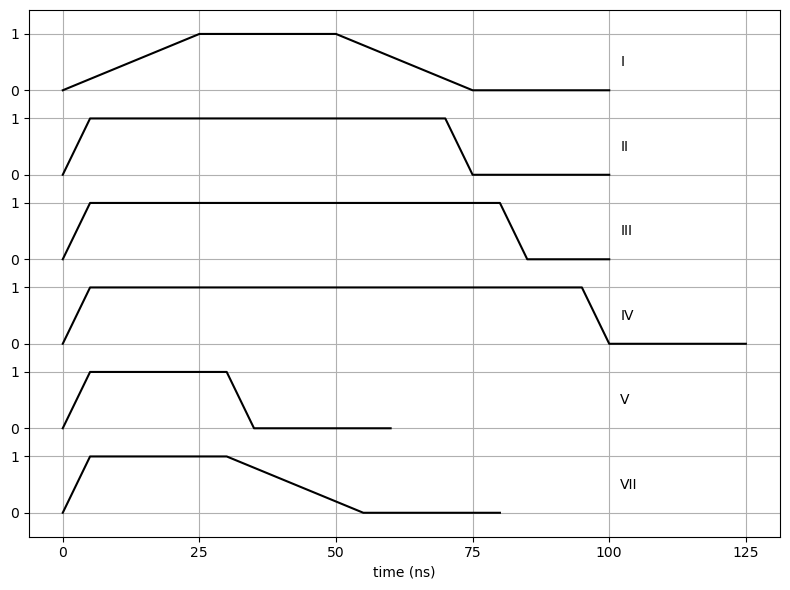

In [9]:
# Final adjustments: make each curve black and remove the title

fig, ax = plt.subplots(figsize=(8, 6))
offset = 0  # Initial offset for the first curve
spacing = 1.5  # Maintain the increased spacing
yticks = []  # Collect y-tick positions
yticklabels = []  # Collect y-tick labels

# Loop through each profile type in reversed order and plot with offsets
for i, (profile_type, s_phases) in enumerate(reversed_profiles[['Profile Type', 'S_phases']].values):
    if s_phases is not None:
        # Generate time and force profile
        time, force = generate_force_profile(s_phases, 1)
        ax.plot(time, np.array(force) + offset, color='black')
        
        # Add direct label at the end of each curve
        ax.text(102, offset + 0.5, profile_type, va='center', ha='left', fontsize=10, color='black')
        
        # Collect the 0 and 1 tick positions and labels for this curve
        yticks.extend([offset, offset + 1])
        yticklabels.extend(["0", "1"])
        
        # Increment offset with increased spacing for the next profile
        offset += spacing

# Set custom y-ticks and labels to show only 0 and 1 for each curve
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xticks(np.arange(0,150,25))

# Removing title and maintaining grid
ax.set_xlabel("time (ns)")
ax.grid(True)

plt.tight_layout()
plt.show()
